In [159]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import sklearn
import torch

# Descomprimimos el datsset.

In [160]:
from zipfile import ZipFile
import os

data_path = "./data"

if len(files := os.listdir(data_path)) == 1:
    print("DESCOMPRIMIENTO DATASET...")
    my_zip_file = ZipFile(data_path + '/' + files[0])
    my_zip_file.extractall(data_path)
else:
    print("EL DATASET YA ESTA DESCOMPRIMIDO")

EL DATASET YA ESTA DESCOMPRIMIDO


# Uso de acelerador hardare

detectamos y guardamos el device que se corresponde a la tarjeta grafica del ordenador que estamos utilizando.

In [161]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 2060'

# Carga de datos:

## Cargamos el csv

In [162]:
path = "./data/flechas/dataset_cleaned.csv"

In [163]:
df = pd.read_csv(
    path,
    sep="\t",
    names=["path", "angle"]
)

df["sin"] =  np.sin(df.angle * 2 * np.pi)
df["cos"] =  np.cos(df.angle * 2 * np.pi)

df.head(10)

,path,angle,sin,cos
0,dataset/lyrs=y&x=498928&y=388383&z=20-0.png,0.747256,-0.999851,-0.017239
1,dataset/lyrs=y&x=498933&y=388386&z=20-1.png,0.085187,0.510054,0.860142
2,dataset/lyrs=y&x=498934&y=388391&z=20-2.png,0.634782,-0.749204,-0.662340
3,dataset/lyrs=y&x=498934&y=388391&z=20-3.png,0.140102,0.770920,0.636932
4,dataset/lyrs=y&x=498940&y=388395&z=20-4.png,0.887765,-0.648182,0.761485
5,dataset/lyrs=y&x=498940&y=388396&z=20-5.png,0.383562,0.668060,-0.744107
6,dataset/lyrs=y&x=498940&y=388396&z=20-6.png,0.377128,0.697588,-0.716499
7,dataset/lyrs=y&x=498940&y=388396&z=20-7.png,0.889370,-0.640467,0.767985
8,dataset/lyrs=y&x=498941&y=388397&z=20-8.png,0.385122,0.660736,-0.750619
9,dataset/lyrs=y&x=498941&y=388397&z=20-9.png,0.380757,0.681070,-0.732218


a continuacion realizamos el train test split.

In [164]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

## Definimos un dataset personalizado.

Un dataset pytorch se define mediante una clase personalizada. Que debe implementar dos metodos principales que son los siguientes.

- Getitem: 
- len:


### preprocesamiento de imagen.

Para definir el dataset nos apoyaremos en la funcion process(path) que encapsulara todo el preprocesamiento que deseamos hacerle a una imagen.

In [165]:
import torchvision.transforms.functional as F_t
import random


def preprocess(path, size=(64, 64)):
    """A priori solo cargamos la imagen y nos aseguramos de que mida 64 x 64"""

    img_path = "data/flechas/" + path
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, size)
    img = F_t.to_tensor(img)

    img = F_t.normalize(
        img,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    # Mantener en CPU; el DataLoader mueve a device en el train loop (evita fallos con num_workers y CUDA).
    return img.to(device)

def gen_mod(img_tensor, angle):

    theta = np.random.random()
    rotated_img = F_t.rotate(img_tensor, theta * 360)
    return (angle + theta) % 1, rotated_img
    

In [166]:
# testeamos que el preprocesamiento sea correcto.

idx = 227

processed_img = preprocess(df["path"][idx])
angle = df["angle"][idx]

print(f"La imagen procesada es de tipo: {type(processed_img)}")
print(f"La imagen procesada tiene un tamao: {processed_img.shape}")
print(f"la imagen tiene valores entre los puntos {processed_img.max().item(), processed_img.min().item()}")

La imagen procesada es de tipo: <class 'torch.Tensor'>
La imagen procesada tiene un tamao: torch.Size([3, 64, 64])
la imagen tiene valores entre los puntos (2.6051416397094727, -1.983193278312683)


In [167]:
# Vemos que se puede recuperar la imagen original.

def plt_img_from_processed_tensor(processed_img):
    processed_img = np.transpose(processed_img, [1, 2, 0])
    a, b = processed_img.min(), processed_img.max()
    processed_img = (processed_img - a) / (b - a)
    plt.imshow(processed_img.numpy())
    plt.axis("off")

0.49875870097859365


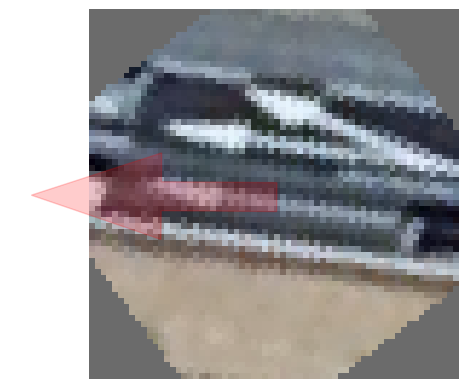

In [168]:
# Probamos el transformador de imagenes medaitne rotaciones aleatorias.

angle, processed_img = gen_mod(processed_img, angle)
plt_img_from_processed_tensor(processed_img.cpu())
sin = np.sin(angle * 2 * np.pi)
cos = np.cos(angle * 2 * np.pi)
plt.arrow(32, 32, cos*20, -sin*20, width=5, color="red", alpha=0.2)
print(angle)

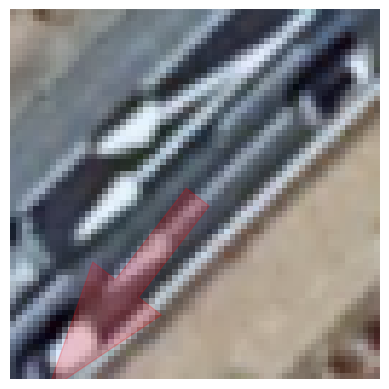

In [169]:
processed_img = preprocess(df["path"][227])
angle = df["angle"][227]
plt.arrow(32, 32, np.cos(angle * 2 * np.pi)*20, -np.sin(angle * 2 * np.pi)*20, width=5, color="red", alpha=0.2)
plt_img_from_processed_tensor(processed_img.cpu())

La visualizacion se complica por que estamos pasando valores que pueden ser negatimos pero si normalizamos en (0, 1) vemos que en realidad el procesamiento que le estamos haciendo a la imagen es bastante basico.

### Data augmentation.

In [170]:
df

,path,angle,sin,cos
0,dataset/lyrs=y&x=498928&y=388383&z=20-0.png,0.747256,-0.999851,-0.017239
1,dataset/lyrs=y&x=498933&y=388386&z=20-1.png,0.085187,0.510054,0.860142
2,dataset/lyrs=y&x=498934&y=388391&z=20-2.png,0.634782,-0.749204,-0.662340
3,dataset/lyrs=y&x=498934&y=388391&z=20-3.png,0.140102,0.770920,0.636932
4,dataset/lyrs=y&x=498940&y=388395&z=20-4.png,0.887765,-0.648182,0.761485
...,...,...,...,...
6696,dataset/lyrs=y&x=530663&y=391686&z=20-7116.png,0.514914,-0.093573,-0.995612
6697,dataset/lyrs=y&x=530669&y=391622&z=20-7117.png,0.385349,0.659666,-0.751559
6698,dataset/lyrs=y&x=530672&y=391647&z=20-7118.png,0.652626,-0.818604,-0.574358
6699,dataset/lyrs=y&x=530676&y=391636&z=20-7119.png,0.598877,-0.582063,-0.813144


In [171]:
train_df["processed_img"] = train_df["path"].map(preprocess)
test_df["processed_img"] = test_df["path"].map(preprocess)

In [172]:
train_df.columns

Index(['path', 'angle', 'sin', 'cos', 'processed_img'], dtype='str')

In [173]:
def augment_df(df : pd.DataFrame, n_mods:int = 1):
    new_rows = []

    for _ in range(n_mods):
        for row in df.itertuples():

            processed_img = row.processed_img
            angle = row.angle

            new_angle, new_img = gen_mod(processed_img.cpu(), angle)

            new_rows.append([None, new_angle, np.sin(new_angle * 2 * np.pi),  np.cos(new_angle * 2 * np.pi), new_img])

    augmented_df = pd.concat([df, pd.DataFrame(new_rows, columns=df.columns)], ignore_index=True, axis=0)
    augmented_df.reset_index(inplace=True, drop=True)
    return augmented_df

#train_df = augment_df(df = train_df, n_mods=1)

### Definicion del dataset

In [174]:
from torch.utils.data import Dataset

class ArrowsDS(Dataset):
    def __init__(self, df, size=(64, 64)):
        super().__init__()
        self.size = size
        self.df : pd.DataFrame = df.reset_index(drop=True)

        self.df["processed_img"] = self.df["path"].map(lambda p: preprocess(p, size=self.size))

    def __getitem__(self, index):
        
        img_tensor = self.df.loc[index, ["processed_img"]].values[0]

        angle_sincos = self.df.loc[index, ["sin", "cos"]].values

        return (
            img_tensor,
            torch.tensor(np.array(angle_sincos, dtype=np.float32))
        )

    def __len__(self):
        return len(self.df)

In [175]:
# creamos los datasets de entrenamiento y de test

train_arrows_ds = ArrowsDS(train_df, size=(64, 64))
test_arrows_ds = ArrowsDS(test_df, size=(64, 64))

en este punto podemos jugar con brillo contraste y sobre toro traslaciones cropys y rotaciones para ampliar mucho el dataset de train NO EL DEL TEST

# Creacion del modelo:

In [176]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Basic_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.regressor = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(128, 2)
        )


    def forward(self, x):
        x = self.features(x)
        return self.regressor(x)

instanciemos la cnn y veamos algunas de sus caracteristicas.

In [177]:
## Vemos un resumen de la rnn que hemos definido.

basecnn = Basic_cnn().to(device)
print(basecnn)

Basic_cnn(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=1)
  )
  (regressor): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [178]:
# veamos cuantos parametros hay por cada capa de la red:

for name, parameters in basecnn.named_parameters():
    print(f"{name:<30}  {parameters.numel():>10,}")

features.0.weight                    2,400
features.0.bias                         32
features.3.weight                   18,432
features.3.bias                         64
features.6.weight                   73,728
features.6.bias                        128
regressor.1.weight                     256
regressor.1.bias                         2


Veamos si funciona el fordardpass si le pasamos una imagen cualquiera.

[]

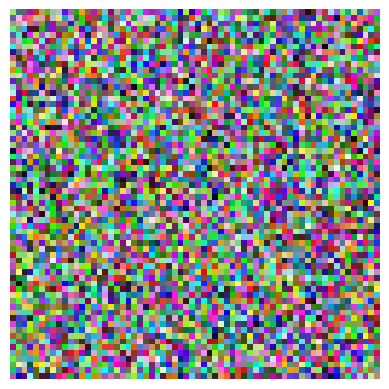

In [179]:
from torchvision.transforms.functional import to_pil_image

randimg_tensor = torch.rand((1 ,3, 64, 64)).to(device)
pil_rand_img = to_pil_image(randimg_tensor.cpu()[0, :, :, :])
plt.imshow(pil_rand_img)
plt.axis("off")
plt.plot()

In [180]:
## Comprobamos que se obtiene un resultado del forward.

basecnn.forward(randimg_tensor)

tensor([[0.1021, 0.1095]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Bucle de entrenamiento.

### Definimos el dataloader:

In [181]:
from torch.utils.data import DataLoader

train_dl = DataLoader(
    dataset=train_arrows_ds,
    batch_size=16,
    shuffle=True,
)

test_dl = DataLoader(
    dataset=test_arrows_ds,
    batch_size=16,
)

In [182]:
len(test_dl)

42

### Definimos el bucle de entrenamiento.

In [183]:
def non_diferientable_loss(a, b):
     a_sin, a_cos = a
     b_sin, b_cos = b

     angle_a = np.degrees(np.arctan2(a_sin, a_cos)) % 360
     angle_b = np.degrees(np.arctan2(b_sin, b_cos)) % 360

     abs_dif = abs(angle_a - angle_b)

     return min(
          abs_dif,
          360 - abs_dif
)

vectoriced_non_diferientable_loss = np.vectorize(non_diferientable_loss)

In [184]:
def test_error(model, test_dl):
    model.eval()
    ground_truth = []
    pred = []

    for _, (batch_img, ground_truth_batch) in enumerate(test_dl):

        with torch.no_grad():
            ground_truth_batch = ground_truth_batch.to(device)
            batch_img = batch_img.to(device)
            output = model(batch_img).to(device)

            ground_truth.extend(ground_truth_batch.cpu().numpy())
            pred.extend(output.cpu().numpy())

    ground_truth = np.array(ground_truth)
    pred = np.array(pred)

    results = np.mean([non_diferientable_loss(a, b) for a, b in zip(ground_truth, pred)])
    return results


In [185]:
basecnn = Basic_cnn().to(device)

def train(model, train_dl, test_dl, loss, optimizer, epochs = 10):
    model = model.to(device)
    i = 0
    print_test_error = True 
    print_interval = 500
    cum_loss = 0

    for epoch in range(epochs):
        for _, (batch_img, ground_truth_batch) in enumerate(train_dl):
            ground_truth_batch = ground_truth_batch.to(device)
            batch_img = batch_img.to(device)
            output = model(batch_img)

            loss_val : torch.Tensor = loss(ground_truth_batch, output)
            cum_loss += loss_val.item()

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
        

            i += 1

            if i%print_interval == 0:
                print(f"Epoch: {epoch} - iteracion: {i}")
                if print_test_error:
                    print(f"Loss Train: {cum_loss/print_interval} - Test error: {test_error(model, test_dl)} grados")
                    model.train()
                else:
                    print(f"Loss Train: {cum_loss/print_interval}")
                    cum_loss = 0

                cum_loss = 0

In [186]:
basecnn = Basic_cnn().to(device)

loss = nn.MSELoss()

# Adam (no AdamW), lr alto y sin weight_decay para que la red salga de predicciones ~(0,0)
optimizer = torch.optim.Adam(basecnn.parameters(), lr=1e-3)

# Opcional: después de que baje el loss, puedes cambiar a AdamW(lr=1e-3, weight_decay=1e-4)
# y entrenar más épocas para refinar.


In [187]:
train(basecnn, train_dl, test_dl, loss, optimizer, epochs=50)

Epoch: 1 - iteracion: 500
Loss Train: 0.5009459063410759 - Test error: 89.87867736816406 grados
Epoch: 2 - iteracion: 1000
Loss Train: 0.5002335446476937 - Test error: 90.38428497314453 grados
Epoch: 3 - iteracion: 1500
Loss Train: 0.5000761408209801 - Test error: 90.3421630859375 grados
Epoch: 5 - iteracion: 2000
Loss Train: 0.4995691012144089 - Test error: 84.34610748291016 grados
Epoch: 6 - iteracion: 2500
Loss Train: 0.4958377692103386 - Test error: 83.24890899658203 grados
Epoch: 7 - iteracion: 3000
Loss Train: 0.49318505376577376 - Test error: 84.64765930175781 grados
Epoch: 9 - iteracion: 3500
Loss Train: 0.48937048637866976 - Test error: 81.69878387451172 grados
Epoch: 10 - iteracion: 4000
Loss Train: 0.4837358241677284 - Test error: 79.65423583984375 grados
Epoch: 11 - iteracion: 4500
Loss Train: 0.47637197935581205 - Test error: 75.60321807861328 grados
Epoch: 13 - iteracion: 5000
Loss Train: 0.4561903392672539 - Test error: 65.4020767211914 grados
Epoch: 14 - iteracion: 5500

# Definimos el bucle de evaluacion:

In [188]:
ground_truth = []
pred = []

basecnn.eval()

for i, (batch_img, ground_truth_batch) in enumerate(test_dl):
        with torch.no_grad():

            ground_truth_batch = ground_truth_batch.to(device)
            batch_img = batch_img.to(device)
            output = basecnn(batch_img).to(device)

            ground_truth.extend(ground_truth_batch.cpu().numpy())
            pred.extend(output.cpu().numpy())

ground_truth = np.array(ground_truth)
pred = np.array(pred)

In [189]:
print(ground_truth.shape)
print(pred.shape)

(671, 2)
(671, 2)


In [190]:
df_results = pd.DataFrame(pred, columns=["sin", "cos"])
df_results["tan"] = df_results["sin"] / df_results["cos"]
df_results["angle"] = np.degrees(np.arctan2(df_results["sin"], df_results["cos"])) % 360
df_results["real_angle"] = np.degrees(np.arctan2(ground_truth[:,0], ground_truth[:,1])) % 360
diff = abs(df_results["real_angle"] - df_results["angle"])
df_results["angle_diff"] = np.minimum(diff, 360 - diff)
df_results["angle_diff_percent"] = df_results["angle_diff"]/360 *100


In [191]:
print(f"porcentaje medio de error: {df_results['angle_diff_percent'].mean()}")
print(f"Angulo medio de error: {df_results['angle_diff'].mean()} grados")

porcentaje medio de error: 5.453731060028076
Angulo medio de error: 19.633432388305664 grados


## Visualizacion de resultados:

puedes ejecutar la siguiente cerlda varias veces para visualizar diferentes imagenes del dataset de test y sus correspondientes predicciones.

revisar codigo

angulo real: 278.6660301709181 grados
angulo predicho: 279.5705480919401 grados
error: 0.904517921022034 grados


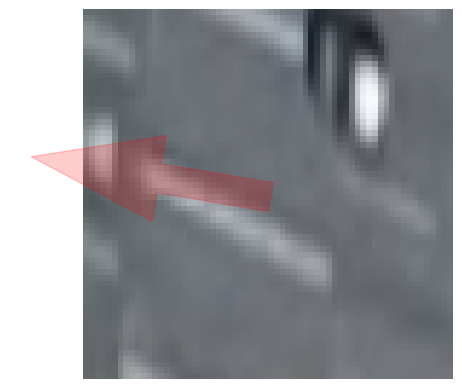

In [192]:
import random

test_row = test_df.sample(1)
path = "data/flechas/" + test_row.path.values[0]
img_pil = cv.imread(path)
img_pil = cv.cvtColor(img_pil, cv.COLOR_BGR2RGB)
plt.imshow(img_pil)
plt.axis("off")

ground_truth_sin = test_row.sin.values[0]
ground_truth_cos = test_row.cos.values[0]

output = basecnn(preprocess(test_row.path.values[0]).reshape(1, 3, 64, 64).to(device)).to(device)
pred_sin, pred_cos = output[0][0].item(), output[0][1].item()
plt.arrow(32, 32, pred_sin*20, -pred_cos*20, width=5, color="red", alpha=0.2)
plt.plot()

print(f"angulo real: {np.degrees(np.arctan2(ground_truth_sin, ground_truth_cos)) % 360} grados")
print(f"angulo predicho: {np.degrees(np.arctan2(pred_sin, pred_cos)) % 360} grados")
print(f"error: {non_diferientable_loss((ground_truth_sin, ground_truth_cos), (pred_sin, pred_cos))} grados")

In [193]:
sum([param.numel() for param in basecnn.parameters()])

95042

# Pruebas con transfer learning:

importamos vgg16, que es un modelo creado para clasificacion de imagenes con 10 clases.

In [200]:
from torchvision.models import vgg16

my_vgg16 = vgg16(weights='IMAGENET1K_V1').to(device)


print("\nImprimimos todas las capas")
print(my_vgg16)


Imprimimos todas las capas
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, str

comprobamos que la red tiene 3 modulos:

- una secuencia de convoluciones.
- una que aplana.
- una secuencia lineal.

### Congelamos los pesos de la secuencia de convoluciones.

In [201]:
for param in my_vgg16.features.parameters():
    param.requires_grad = False

### modificamos la capa classifier:



In [202]:
my_vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=512, out_features=2),
 ).to(device)

# aseguramos que la nueva parte también esté en el dispositivo correcto
my_vgg16 = my_vgg16.to(device)

In [203]:
resized_train_arrows_ds = ArrowsDS(train_df, size=(224, 224))
resized_test_arrows_ds = ArrowsDS(test_df, size=(224, 224))

resized_train_dl = DataLoader(
    dataset=resized_train_arrows_ds,
    batch_size=8,
    shuffle=True,
)

resized_test_dl = DataLoader(
    dataset=resized_test_arrows_ds,
    batch_size=8,
    shuffle=False,
)

In [204]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(my_vgg16.parameters(), lr=0.0001)

train(my_vgg16, resized_train_dl, resized_test_dl, loss, optimizer, epochs=5)

Epoch: 0 - iteracion: 500
Loss Train: 0.33300367984175683 - Test error: 35.08654022216797 grados
Epoch: 1 - iteracion: 1000
Loss Train: 0.19168554943799973 - Test error: 31.83540153503418 grados
Epoch: 1 - iteracion: 1500
Loss Train: 0.14304193096607923 - Test error: 28.904457092285156 grados


KeyboardInterrupt: 